In [13]:
from ls_mlkit.my_diffuser import Diffuser, ModelInterface4Diffuser, DiffusionConfig  # type: ignore
from ls_mlkit.my_utils import HF_MIRROR  # type: ignore
from typing import Any
import torch  # type: ignore
from torch import Tensor
from ls_mlkit.my_utils import ImageMasker,set_proxy  # type: ignore

set_proxy()

# !pip install diffusers
from diffusers import DDPMPipeline, DDIMPipeline, PNDMPipeline  # type: ignore

from diffusers.models.unets.unet_2d import UNet2DModel, UNet2DOutput  # type: ignore

# model_id = "google/ddpm-celebahq-256"
model_id = "google/ddpm-cat-256"


class Unet(ModelInterface4Diffuser):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model: torch.nn.Module = model

    def get_model_device(self):
        return next(self.model.parameters()).device

    def prepare_batch_data_for_input(self, batch: dict[str, Any]):
        return batch

    def __call__(self, x_t: Tensor, t: Tensor, padding_mask: Tensor) -> Tensor:
        result: UNet2DOutput = self.model.forward(x_t, t)  # type: ignore
        return result["sample"]



In [14]:
from diffusers import DDPMScheduler, UNet2DModel

scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")

In [15]:
_model = Unet(model)  # type: ignore

diffusion_config = DiffusionConfig(ndim_micro_shape=3)

diffuser = Diffuser(model=_model, config=diffusion_config, masker=ImageMasker())

In [16]:
import torch
from tqdm.auto import tqdm
sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size), device="cuda")
print(sample_size)


# input = noise

# for t in tqdm(scheduler.timesteps):
#     with torch.no_grad():
#         noisy_residual = model(input, t).sample
#     previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
#     input = previous_noisy_sample


256


In [ ]:
from PIL import Image
import numpy as np


def tensor_to_image(tensor_input):
    print(tensor_input.shape)
    image = (tensor_input / 2 + 0.5).clamp(0, 1).squeeze()
    image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
    image = Image.fromarray(image)
    return image

# tensor_to_image(input)

0it [00:00, ?it/s]

torch.Size([1, 3, 256, 256])


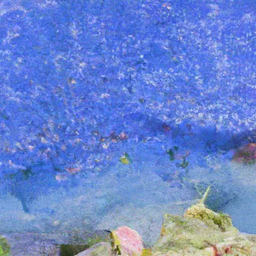

In [ ]:
result:Tensor = diffuser.sample_x0_unconditionally(shape=(1,3,256,256))

tensor_to_image(result)

torch.Size([1, 3, 256, 256])


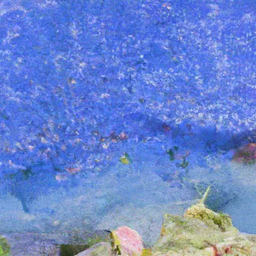

In [ ]:
tensor_to_image(result)

In [ ]:
print(scheduler.timesteps)

tensor([999, 998, 997, 996, 995, 994, 993, 992, 991, 990, 989, 988, 987, 986,
        985, 984, 983, 982, 981, 980, 979, 978, 977, 976, 975, 974, 973, 972,
        971, 970, 969, 968, 967, 966, 965, 964, 963, 962, 961, 960, 959, 958,
        957, 956, 955, 954, 953, 952, 951, 950, 949, 948, 947, 946, 945, 944,
        943, 942, 941, 940, 939, 938, 937, 936, 935, 934, 933, 932, 931, 930,
        929, 928, 927, 926, 925, 924, 923, 922, 921, 920, 919, 918, 917, 916,
        915, 914, 913, 912, 911, 910, 909, 908, 907, 906, 905, 904, 903, 902,
        901, 900, 899, 898, 897, 896, 895, 894, 893, 892, 891, 890, 889, 888,
        887, 886, 885, 884, 883, 882, 881, 880, 879, 878, 877, 876, 875, 874,
        873, 872, 871, 870, 869, 868, 867, 866, 865, 864, 863, 862, 861, 860,
        859, 858, 857, 856, 855, 854, 853, 852, 851, 850, 849, 848, 847, 846,
        845, 844, 843, 842, 841, 840, 839, 838, 837, 836, 835, 834, 833, 832,
        831, 830, 829, 828, 827, 826, 825, 824, 823, 822, 821, 8